<a href="https://colab.research.google.com/github/NichBry25/BitcoinPricePrediction/blob/main/BTCForecasting_TCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ensures results are replicable

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import random

In [3]:
# Ensures results are replicable

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [4]:
df = pd.read_csv('btc_forecasting_dataset3.csv')

In [5]:
df

,Date,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,xau_logret_lag3,xau_logret_lag7,vix_logret_lag1,vix_logret_lag3,vix_logret_lag7,dxy_logret_lag1,dxy_logret_lag3,dxy_logret_lag7,btc_ma50,btc_ma200
0,2015-07-20,277.7,273.2,278.9,271.8,46600.0,2128.30,1096.95,12.25,98.03,...,-0.009696,-0.005134,0.000000,-0.013300,-0.191274,0.000000,0.001943,0.008606,252.782,246.4990
1,2015-07-21,275.1,277.7,281.0,274.2,49050.0,2119.20,1101.41,12.22,97.33,...,0.000000,-0.002135,0.024795,0.000000,-0.038875,0.001736,0.000000,-0.002274,253.822,246.2985
2,2015-07-22,276.5,275.1,277.4,273.1,41970.0,2114.20,1093.45,12.12,97.60,...,0.000000,-0.005102,-0.002452,0.000000,-0.010526,-0.007166,0.000000,0.005469,254.838,246.2455
3,2015-07-23,275.5,276.5,277.9,274.5,35660.0,2102.20,1090.80,12.64,97.11,...,-0.033306,-0.003922,-0.008217,0.024795,-0.088455,0.002770,0.001736,0.005132,255.836,246.2995
4,2015-07-24,288.4,275.5,289.8,274.3,74360.0,2079.70,1099.10,13.74,97.24,...,0.004058,-0.009696,0.042009,-0.002452,-0.013300,-0.005033,-0.007166,0.001943,257.120,246.3675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,2025-10-27,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,-0.003416,0.024755,0.000000,-0.055256,-0.130922,0.000000,0.000101,0.001624,114272.866,108948.3695
3753,2025-10-28,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,0.000000,-0.054579,-0.036074,0.000000,-0.019945,-0.001720,0.000000,0.003443,114289.614,109095.8330
3754,2025-10-29,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,0.000000,-0.007551,0.039123,0.000000,0.040038,-0.001114,0.000000,-0.000303,114259.776,109219.4925
3755,2025-10-30,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,-0.032253,0.007810,0.029996,-0.036074,-0.072455,0.005559,-0.001720,0.000404,114146.908,109342.4210


Anything beyond this section ending with "1" is representing the dataframe WITHOUT macro features. While "2" is representing WITH macro features.

In [6]:
TARGET = 'btc_logret'

In [7]:
FEATURES_1 = [
    'btc_price', 'open', 'high', 'low', 'volume',
    'btc_ma50', 'btc_ma200'
]

In [8]:
FEATURES_2 = [
    'btc_price','open','high','low','volume',
    'spx_price','xau_price', 'vix_price', 'dxy_price',
    'spx_logret','xau_logret', 'vix_logret', 'dxy_logret',
    'spx_logret_lag1','spx_logret_lag3','spx_logret_lag7',
    'xau_logret_lag1','xau_logret_lag3','xau_logret_lag7',
    'vix_logret_lag1','vix_logret_lag3','vix_logret_lag7',
    'dxy_logret_lag1','dxy_logret_lag3','dxy_logret_lag7',
    'btc_ma50','btc_ma200'
]

# Train - Val - Test Split

In [9]:
total_len = len(df)

In [10]:
train_end = int(total_len * 0.7)
val_end = int(total_len * 0.85)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

In [11]:
train_df.shape

(2629, 29)

In [12]:
val_df.shape

(564, 29)

In [13]:
test_df.shape

(564, 29)

# Scaling

In [14]:
scaler_1 = MinMaxScaler()

In [15]:
scaler_1.fit(train_df[FEATURES_1])

MinMaxScaler()

In [16]:
train_scaled_1 = scaler_1.transform(train_df[FEATURES_1])
val_scaled_1   = scaler_1.transform(val_df[FEATURES_1])
test_scaled_1  = scaler_1.transform(test_df[FEATURES_1])

In [17]:
scaler_2 = MinMaxScaler()

In [18]:
scaler_2.fit(train_df[FEATURES_2])

MinMaxScaler()

In [19]:
train_scaled_2 = scaler_2.transform(train_df[FEATURES_2])
val_scaled_2   = scaler_2.transform(val_df[FEATURES_2])
test_scaled_2  = scaler_2.transform(test_df[FEATURES_2])

In [20]:
y_train_full = train_df[TARGET].values
y_val_full   = val_df[TARGET].values
y_test_full  = test_df[TARGET].values

# Create Sequence Data

In [21]:
def make_sequence_data(values, target, lookback):
    X, y = [], []
    for i in range(lookback, len(values)):
        X.append(values[i - lookback:i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [22]:
LOOKBACK = 60

In [23]:
X_train_1, y_train_1 = make_sequence_data(train_scaled_1, y_train_full, LOOKBACK)
X_val_1, y_val_1 = make_sequence_data(val_scaled_1, y_val_full, LOOKBACK)
X_test_1, y_test_1 = make_sequence_data(test_scaled_1, y_test_full, LOOKBACK)

In [24]:
X_train_2, y_train_2 = make_sequence_data(train_scaled_2, y_train_full, LOOKBACK)
X_val_2, y_val_2 = make_sequence_data(val_scaled_2, y_val_full, LOOKBACK)
X_test_2, y_test_2 = make_sequence_data(test_scaled_2, y_test_full, LOOKBACK)

# Metrics

In [25]:
def calculate_performance_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  da = np.mean((y_test * y_pred) > 0)
  return {"MSE": mse, "RMSE": rmse, "MAE": mae, "DA": da}

# Modelling

In [26]:
from itertools import product

In [27]:
GRID = {
    "filters": [32, 64],
    "kernel_size": [3, 5],
    "dilation_depth": [3, 4],
    "learning_rate": [0.001, 0.003],
    "batch_size": [32, 64],
}

grid_combinations = list(product(
    GRID["filters"],
    GRID["kernel_size"],
    GRID["dilation_depth"],
    GRID["learning_rate"],
    GRID["batch_size"],
))

In [28]:
len(grid_combinations)

32

In [29]:
initializer = tf.keras.initializers.GlorotUniform(seed=42)

In [30]:
def TCN_block(x, filters, kernel_size, dilation_rate):
  y = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate,
                    padding="causal", activation="relu", kernel_initializer=initializer,
                    bias_initializer='zeros')(x)
  y = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate,
                    padding="causal", activation="relu", kernel_initializer=initializer,
                    bias_initializer='zeros')(y)

  if x.shape[-1] != filters:
    x = layers.Conv1D(filters, 1, padding="same", kernel_initializer=initializer,
                      bias_initializer='zeros')(x)

  return layers.Add()([x, y])

In [31]:
def build_tcn(input_shape, filters, kernel_size, dilation_depth, learning_rate):
  inputs = layers.Input(shape=input_shape)

  x = inputs
  for i in range(dilation_depth):
    x = TCN_block(x, filters=filters, kernel_size=kernel_size, dilation_rate=2 ** i)

  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dense(32, activation="relu", kernel_initializer=initializer, bias_initializer='zeros')(x)
  outputs = layers.Dense(1, kernel_initializer=initializer, bias_initializer='zeros')(x)  # Predict 1 day log-return

  model = models.Model(inputs, outputs)
  model.compile(
      optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
      loss="mse"
  )
  return model

In [32]:
results = []

In [ ]:
for i, (filters, kernel_size, depth, lr, batch_size) in enumerate(grid_combinations, 1):
  print(f"\n[{i}/{len(grid_combinations)}] "
        f"filters={filters}, kernel={kernel_size}, "
        f"dilations={depth}, lr={lr}, batch={batch_size}")

  ## WITHOUT MACRO
  model_1 = build_tcn(
      X_train_1.shape[1:],
      filters,
      kernel_size,
      depth,
      lr
  )

  model_1.fit(
      X_train_1, y_train_1,
      epochs=50,
      batch_size=batch_size,
      validation_data=(X_val_1, y_val_1),
      callbacks = [
          callbacks.EarlyStopping(
              patience=5, restore_best_weights=True, min_delta=0.0
          )
      ],
      verbose=0,
      shuffle=False
  )

  y_pred_1 = model_1.predict(X_test_1).ravel()
  metrics_1 = calculate_performance_metrics(y_test_1, y_pred_1)

  ## WITH MACRO
  model_2 = build_tcn(
      X_train_2.shape[1:],
      filters,
      kernel_size,
      depth,
      lr
  )

  model_2.fit(
      X_train_2, y_train_2,
      epochs=50,
      batch_size=batch_size,
      validation_data=(X_val_2, y_val_2),
      callbacks = [
          callbacks.EarlyStopping(
              patience=5, restore_best_weights=True, min_delta=0.0
          )
      ],
      verbose = 0,
      shuffle=False
  )

  y_pred_2 = model_2.predict(X_test_2).ravel()
  metrics_2 = calculate_performance_metrics(y_test_2, y_pred_2)

  results.append({
      "filters": filters,
      "kernel_size": kernel_size,
      "dilation_depth": depth,
      "learning_rate": lr,
      "batch_size": batch_size,

      "MSE_1": metrics_1['MSE'],
      'MSE_2': metrics_2['MSE'],

      "RMSE_1": metrics_1["RMSE"],
      "RMSE_2": metrics_2["RMSE"],

      "MAE_1": metrics_1["MAE"],
      "MAE_2": metrics_2["MAE"],

      "DA_1": metrics_1["DA"],
      "DA_2": metrics_2["DA"],

      "Macro Better MSE": metrics_2["MSE"] < metrics_1["MSE"],
      "Macro Better RMSE": metrics_2["RMSE"] < metrics_1["RMSE"],
      "Macro Better MAE": metrics_2["MAE"] < metrics_1["MAE"],
      "Macro Better DA": metrics_2["DA"] > metrics_1["DA"],
  })


[1/32] filters=32, kernel=3, dilations=3, lr=0.001, batch=32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

[2/32] filters=32, kernel=3, dilations=3, lr=0.001, batch=64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

[3/32] filters=32, kernel=3, dilations=3, lr=0.003, batch=32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

[4/32] filters=32, kernel=3, dilations=3, lr=0.003, batch=64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

[5/32] filters=32, kernel=3, dilations=4, lr=0.001, batch=32
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

[6/32] filters=32, kernel=3, dilations=4, lr=0.001, batch=64
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

[7/32] filters=32, kernel=3, dilations=4, lr=0.003, batch=32
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

[8/32

# Results

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_df

,filters,kernel_size,dilation_depth,learning_rate,batch_size,MSE_1,MSE_2,RMSE_1,RMSE_2,MAE_1,MAE_2,DA_1,DA_2,Macro Better MSE,Macro Better RMSE,Macro Better MAE,Macro Better DA
0,32,3,3,0.001,32,0.000986,0.236367,0.031398,0.486176,0.024785,0.422257,0.466270,0.488095,False,False,False,True
1,32,3,3,0.001,64,0.001127,0.281145,0.033573,0.530231,0.027303,0.464539,0.458333,0.488095,False,False,False,True
2,32,3,3,0.003,32,0.001261,0.327375,0.035508,0.572167,0.027197,0.511898,0.486111,0.488095,False,False,False,True
3,32,3,3,0.003,64,0.000939,0.336218,0.030649,0.579843,0.023382,0.519338,0.490079,0.488095,False,False,False,False
4,32,3,4,0.001,32,0.000837,2.193305,0.028923,1.480981,0.022643,1.364266,0.480159,0.488095,False,False,False,True
5,32,3,4,0.001,64,0.001083,2.054622,0.032907,1.433395,0.026593,1.312436,0.484127,0.488095,False,False,False,True
6,32,3,4,0.003,32,0.000688,0.913862,0.026227,0.955961,0.019726,0.848966,0.482143,0.488095,False,False,False,True
7,32,3,4,0.003,64,0.000635,0.205807,0.025191,0.453660,0.018514,0.395153,0.484127,0.488095,False,False,False,True
8,32,5,3,0.001,32,0.000604,0.037851,0.024573,0.194552,0.018120,0.173147,0.488095,0.511905,False,False,False,True
9,32,5,3,0.001,64,0.000629,0.021383,0.025082,0.146230,0.018652,0.126441,0.500000,0.511905,False,False,False,True


In [ ]:
results_df.to_csv('tcn_grid_results.csv') # Retraining the model is optional

In [33]:
results_df = pd.read_csv('tcn_grid_results.csv')

In [34]:
best_without_macro = results_df.sort_values("RMSE_1").iloc[0]
best_with_macro = results_df.sort_values("RMSE_2").iloc[0]

In [35]:
best_without_macro

,11
Unnamed: 0,11
filters,32
kernel_size,5
dilation_depth,3
learning_rate,0.003
batch_size,64
MSE_1,0.000597
MSE_2,0.042612
RMSE_1,0.024443
RMSE_2,0.206426


In [36]:
best_with_macro

,29
Unnamed: 0,29
filters,64
kernel_size,5
dilation_depth,4
learning_rate,0.001
batch_size,64
MSE_1,0.0009
MSE_2,0.006577
RMSE_1,0.029997
RMSE_2,0.081099


In [37]:
macro_mse_win_rate = results_df["Macro Better MSE"].mean()
macro_mae_win_rate = results_df['Macro Better MAE'].mean()
macro_da_win_rate = results_df["Macro Better DA"].mean()

In [38]:
macro_mse_win_rate

np.float64(0.0)

In [39]:
macro_mae_win_rate

np.float64(0.0)

In [40]:
macro_da_win_rate

np.float64(0.625)

# Retrain for Plotting

In [41]:
tf.keras.backend.clear_session()

model_1 = build_tcn(X_train_1.shape[1:], best_without_macro['filters'], int(best_without_macro['kernel_size']), best_without_macro['dilation_depth'], best_without_macro['learning_rate'])

In [42]:
history_best_without_macro = model_1.fit(
    X_train_1, y_train_1,
    epochs=50,
    batch_size=int(best_without_macro['batch_size']),
    validation_data=(X_val_1, y_val_1),
    callbacks = [
      callbacks.EarlyStopping(
          patience=5, restore_best_weights=True, min_delta = 0.0
        )
    ],
    verbose=1,
    shuffle=False
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0068 - val_loss: 0.0015
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - val_loss: 9.2473e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 8.5595e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 8.1083e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 7.7681e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 7.5156e-04
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015 - val_loss: 7.3180e-04
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0015 - val_loss: 7.1646e-04
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━

In [43]:
y_pred_1 = model_1.predict(X_test_1).ravel()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [44]:
tf.keras.backend.clear_session()

model_2 = build_tcn(X_train_2.shape[1:], best_with_macro['filters'], int(best_with_macro['kernel_size']), best_with_macro['dilation_depth'], best_with_macro['learning_rate'])

In [45]:
history_best_with_macro = model_2.fit(
    X_train_2, y_train_2,
    epochs=50,
    batch_size=int(best_with_macro['batch_size']),
    validation_data=(X_val_2, y_val_2),
    callbacks = [
      callbacks.EarlyStopping(
          patience=5, restore_best_weights=True, min_delta = 0.0
        )
    ],
    verbose=1,
    shuffle=False
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.1338 - val_loss: 0.0012
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0019 - val_loss: 0.0014


In [46]:
y_pred_2 = model_2.predict(X_test_2).ravel()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


# Price Reconstruction

In [47]:
actual_prices = test_df["btc_price"].iloc[LOOKBACK:].values

In [48]:
prev_actual_prices = test_df["btc_price"].iloc[LOOKBACK-1:-1].values

In [49]:
prev_actual_prices = prev_actual_prices[:len(y_pred_1)]

In [50]:
pred_price_1 = prev_actual_prices * np.exp(y_pred_1[:len(prev_actual_prices)])
pred_price_2 = prev_actual_prices * np.exp(y_pred_2[:len(prev_actual_prices)])

In [51]:
actual_prices = actual_prices[:len(pred_price_1)]

# Plotting

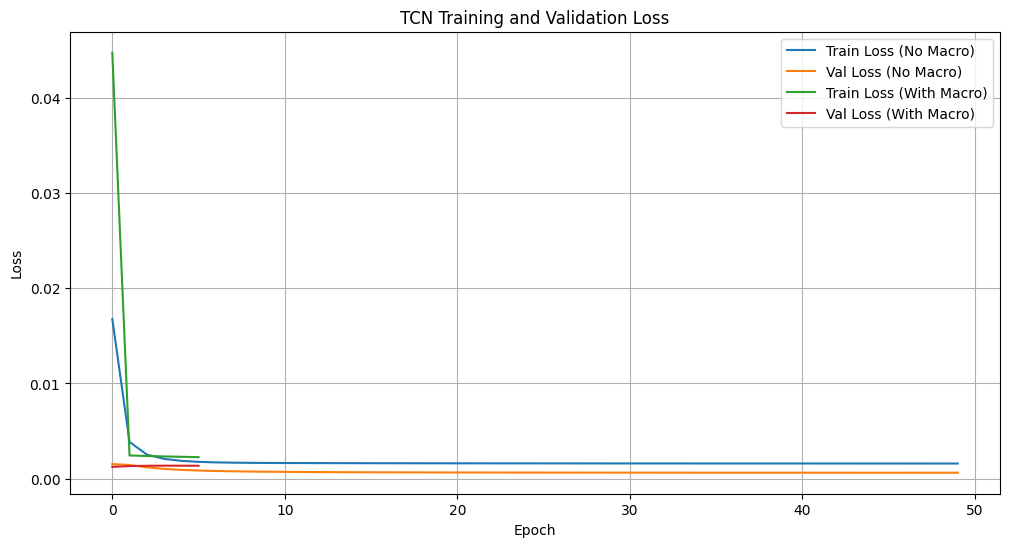

In [52]:
plt.figure(figsize=(12,6))
plt.plot(history_best_without_macro.history["loss"], label="Train Loss (No Macro)")
plt.plot(history_best_without_macro.history["val_loss"], label="Val Loss (No Macro)")
plt.plot(history_best_with_macro.history["loss"], label="Train Loss (With Macro)")
plt.plot(history_best_with_macro.history["val_loss"], label="Val Loss (With Macro)")
plt.title("TCN Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

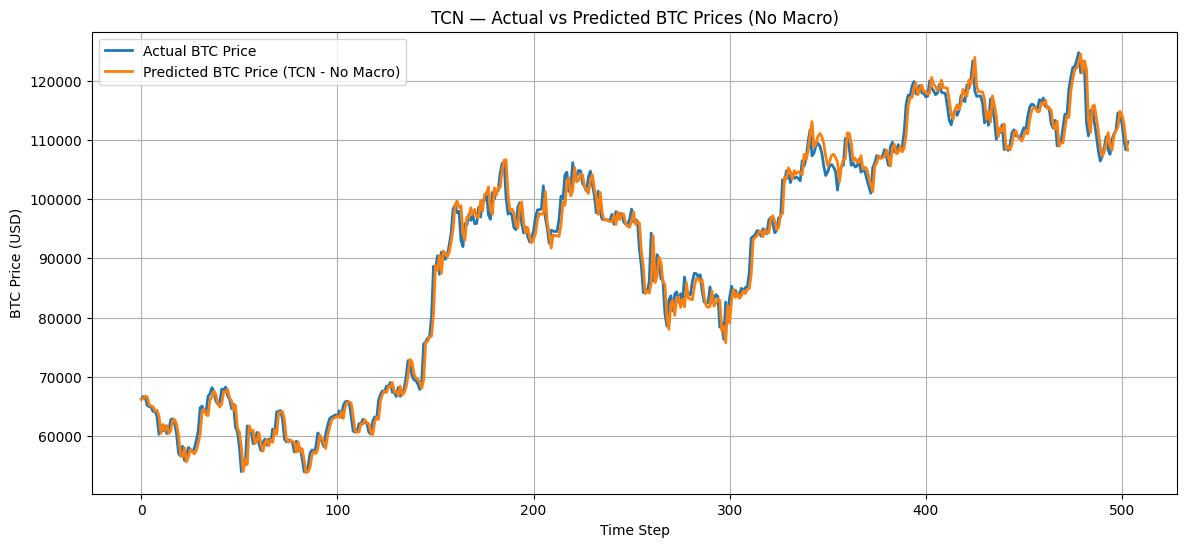

In [53]:
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label="Actual BTC Price", linewidth=2)
plt.plot(pred_price_1, label="Predicted BTC Price (TCN - No Macro)", linewidth=2)
plt.title("TCN — Actual vs Predicted BTC Prices (No Macro)")
plt.xlabel("Time Step")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

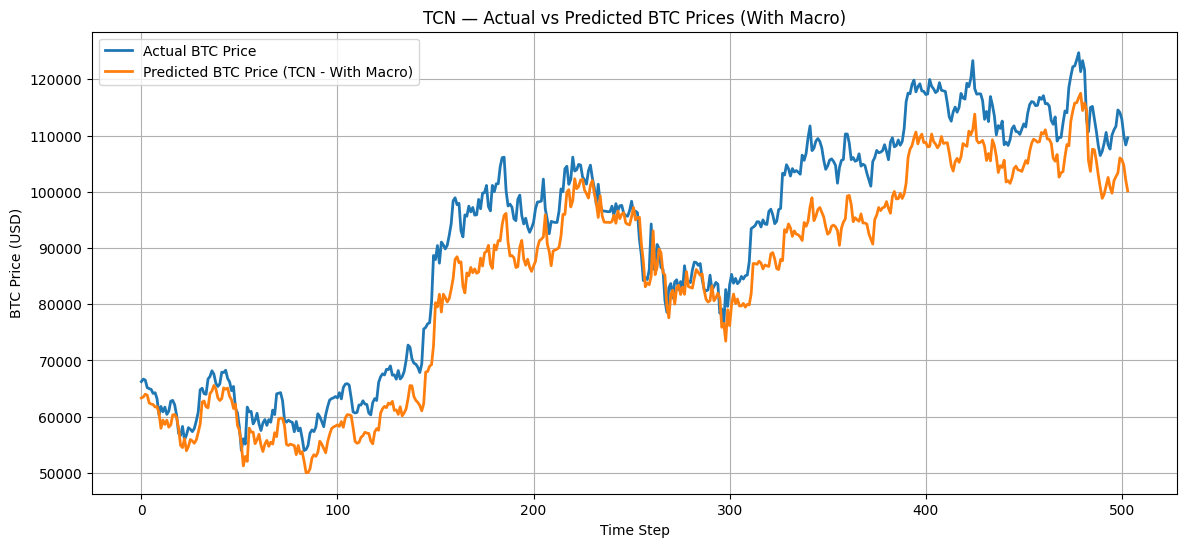

In [54]:
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label="Actual BTC Price", linewidth=2)
plt.plot(pred_price_2, label="Predicted BTC Price (TCN - With Macro)", linewidth=2)
plt.title("TCN — Actual vs Predicted BTC Prices (With Macro)")
plt.xlabel("Time Step")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

 # Significance Test


In [55]:
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import mcnemar

In [56]:
def per_timestep_squared_error(y_true, y_pred):
    return (y_true - y_pred) ** 2

def hac_test_loss_difference(loss_diff, max_lag=5):
    X = np.ones(len(loss_diff))  # intercept only
    model = sm.OLS(loss_diff, X).fit(
        cov_type="HAC",
        cov_kwds={"maxlags": max_lag}
    )
    return {
        "mean_diff": model.params[0],
        "t_stat": model.tvalues[0],
        "p_value": model.pvalues[0]
    }

def mcnemar_direction_test(y_true, y_pred_nomacro, y_pred_macro):
    correct_nomacro = np.sign(y_true) == np.sign(y_pred_nomacro)
    correct_macro = np.sign(y_true) == np.sign(y_pred_macro)

    table = [
        [np.sum(correct_macro & correct_nomacro),
         np.sum(correct_macro & ~correct_nomacro)],
        [np.sum(~correct_macro & correct_nomacro),
         np.sum(~correct_macro & ~correct_nomacro)]
    ]

    result = mcnemar(table, correction=True)
    return {
        "table": table,
        "statistic": result.statistic,
        "p_value": result.pvalue
    }

In [57]:
loss_nomacro = per_timestep_squared_error(y_test_1, y_pred_1)
loss_macro   = per_timestep_squared_error(y_test_2, y_pred_2)

loss_diff = loss_macro - loss_nomacro

In [58]:
hac_result = hac_test_loss_difference(loss_diff, max_lag=5)

print(f"p-value: {hac_result['p_value']:.4f}")

p-value: 0.0000


In [59]:
da_test = mcnemar_direction_test(y_test_1, y_pred_1, y_pred_2)

print(f"p-value: {da_test['p_value']:.4f}")

p-value: 0.7870


# Post-Hoc Statistical Tests

In [60]:
err_no_macro = pred_price_1 - actual_prices

In [61]:
err_macro = pred_price_2 - actual_prices

In [62]:
abs_err_no_macro = np.abs(err_no_macro)

In [63]:
abs_err_macro = np.abs(err_macro)

WMAE

In [64]:
test_logret = test_df['btc_logret'].iloc[LOOKBACK:].values

In [65]:
rolling_vol_60 = (
    pd.Series(test_logret).rolling(window=60).std().values
)

In [66]:
valid_idx = ~np.isnan(rolling_vol_60)

In [67]:
wmae_no_macro = np.sum(abs_err_no_macro[valid_idx] * rolling_vol_60[valid_idx]) / np.sum(rolling_vol_60[valid_idx])
wmae_macro = np.sum(abs_err_macro[valid_idx] * rolling_vol_60[valid_idx]) / np.sum(rolling_vol_60[valid_idx])

In [68]:
print(f"WMAE (No Macro): {wmae_no_macro:.6f}")
print(f"WMAE (With Macro): {wmae_macro:.6f}")
print(f"ΔWMAE: {wmae_macro - wmae_no_macro:.6f}")

WMAE (No Macro): 1627.600038
WMAE (With Macro): 6633.696282
ΔWMAE: 5006.096244


Distributonal Properties of Errors

In [69]:
def distribution_stats(errors):
  return {
      "mean": np.mean(errors),
      "median": np.median(errors),
      "std": np.std(errors),
      "iqr": np.percentile(errors, 75) - np.percentile(errors, 25),
      "min": np.min(errors),
      "max": np.max(errors)
  }

In [70]:
dist_no_macro = distribution_stats(err_no_macro)

In [71]:
dist_macro = distribution_stats(err_macro)

In [72]:
dist_df = pd.DataFrame([dist_no_macro, dist_macro], index=['No Macro', 'With Macro'])

In [73]:
dist_df

,mean,median,std,iqr,min,max
No Macro,-35.307651,-41.202330,2134.931433,2413.939979,-8517.594366,8983.428149
With Macro,-6217.728560,-6242.556125,3890.875713,5913.179190,-15965.398686,6835.846572


Per-Model Macro Effect

In [74]:
tcn_stat_results = {
    "model": "TCN",
    "wmae_no_macro": wmae_no_macro,
    "wmae_macro": wmae_macro,
    "delta_wmae": wmae_macro - wmae_no_macro,
    "std_err_no_macro": dist_no_macro["std"],
    "std_err_macro": dist_macro["std"]
}

In [75]:
pd.DataFrame([tcn_stat_results]).to_csv("tcn_statistical_results.csv", index=False)

# Error Visualization

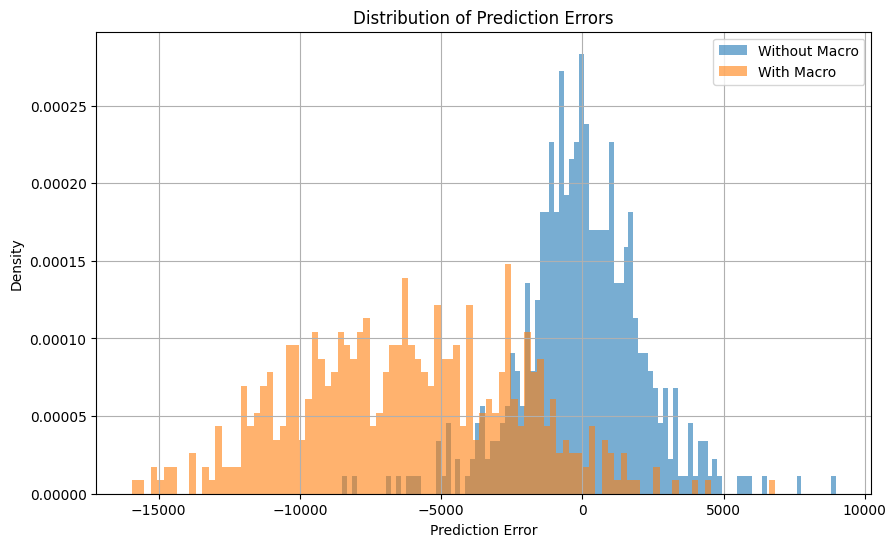

In [76]:
plt.figure(figsize=(10,6))
plt.hist(err_no_macro, bins=100, alpha=0.6, label='Without Macro', density=True)
plt.hist(err_macro, bins=100, alpha=0.6, label='With Macro', density=True)

plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('Distribution of Prediction Errors')
plt.legend()
plt.grid(True)

plt.show()

/tmp/ipython-input-3840640867.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


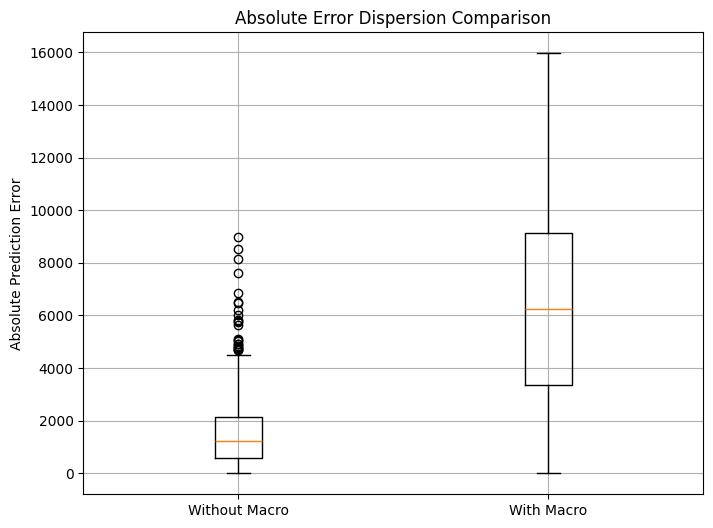

In [77]:
plt.figure(figsize=(8, 6))

plt.boxplot(
    [abs_err_no_macro, abs_err_macro],
    labels=['Without Macro', 'With Macro'],
    showfliers=True
)

plt.ylabel('Absolute Prediction Error')
plt.title('Absolute Error Dispersion Comparison')
plt.grid(True)

plt.show()

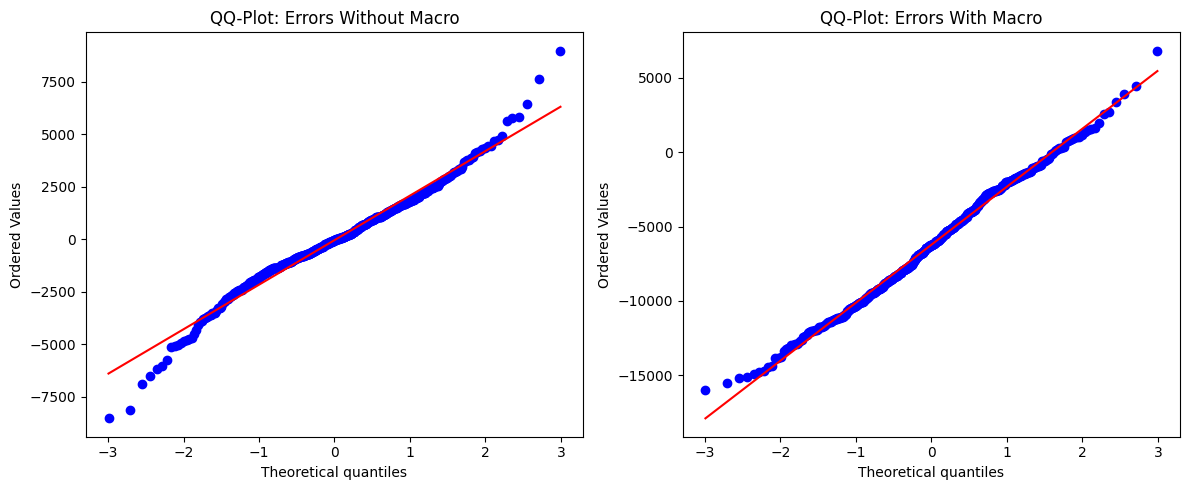

In [78]:
import scipy.stats as stats

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(err_no_macro, dist="norm", plot=plt)
plt.title('QQ-Plot: Errors Without Macro')

plt.subplot(1, 2, 2)
stats.probplot(err_macro, dist="norm", plot=plt)
plt.title('QQ-Plot: Errors With Macro')

plt.tight_layout()
plt.show()